# Optimizing over product states
Now that we have checked that there are operators and states whose description is much cheaper than the normal description (remember that the $W$ state required bond dimension $2$ independently on the number of spins) we are ready to study the optimization of state directly described by Tensor network ansatz.
The simple class of such states are product states, as we saw in the first lecture. 

We will try to find the ground state of a system with PBC in term of a product state. Thus we can use the invariance under tranaslation to argue that the product state will be of the form 
 $$ |\psi  \rangle = \otimes^N |\phi \rangle $$
 
 So let's start defining our initial state. We will define it as a random rotation by an Hermitian matrix applied on the top of the state $|0\rangle$

In [1]:
import numpy as np
import scipy.linalg as LA
ham =np.random.rand(2,2)+1j*np.random.rand(2,2)

ham =ham +ham.T.conj()

phi = np.zeros(2)+1j*np.zeros(2)
phi[0]=1.

phi = LA.expm(-1j*ham)@phi
LA.norm(phi)
print(phi)




[ 0.06868925-0.6977414j  -0.56473308+0.43533352j]


Now given the product state we need a function that computes the energy

In [2]:
def compute_energy(h_two_body,prod_state):
    einsum_path_s =['einsum_path', (0, 4), (0, 3), (0, 2), (0, 1)]
    energy = np.einsum('i,j,k,l,ijkl',prod_state,prod_state,prod_state.conj(),prod_state.conj(),h_two_body,
                       optimize=einsum_path_s)
    return energy

identity = np.eye(2)
v_lambda =0.1

def build_and_diagonalize_H(N,v_lambda):
    identity = np.eye(2)
    sigma_x = np.array([[0.,1.],[1.,0.]])
    sigma_z = np.array([[1.,0.],[0.,-1.]])
    H = -np.kron(sigma_x,sigma_x) + v_lambda*(np.kron(identity,sigma_z)+  np.kron(sigma_z,identity))
    for n in range(3,N+1):
        H = np.kron(H,np.eye(2)) + np.kron(np.eye(2**(n-2)),-np.kron(sigma_x,sigma_x)) + (
        v_lambda*(np.kron(np.eye(2**(n-1)),sigma_z)))
                                                                                                                                                  
    H = H -np.kron(sigma_x, np.kron(np.eye(2**(N-2)),sigma_x))
    eig_H,U_H =LA.eigh(H)
    return H, eig_H, U_H

def build_H2(v_lambda):

    sigma_x = np.array([[0.,1.],[1.,0.]])
    sigma_y = np.array([[0.,-1.j],[1.j,0.]])
    sigma_z = np.array([[1.,0.],[0.,-1.]])
    H = -np.kron(sigma_x,sigma_x) + v_lambda/2*(np.kron(identity,sigma_z)+  np.kron(sigma_z,identity))
    energies,_=LA.eigh(H)

    H = H.reshape(2,2,2,2)
    return energies[0],H

gs_energy,H = build_H2(v_lambda)
energy =np.real_if_close(compute_energy(H,phi))
print(energy)


-0.4710259437281664


We now are almost there, we can define a function that given the correct number of parameters builds the correct state and returns the energy. Since the operator is Hermitian, we only need 6 real parameters,

In [3]:
def construct_state_and_compute_energy(x,ham_two_body):
    herm_operator = np.zeros((2, 2), dtype=complex)
    herm_operator[0,0] = x[0]
    herm_operator[1,1] = x[1]
    herm_operator[1,0] = x[2]+1j*x[3]
    herm_operator[0,1] = x[2]-1j*x[3]
    phi = np.zeros(2,dtype=complex)
    phi[0]=1.
    phi = LA.expm(-1j*herm_operator)@phi
    energy = np.real_if_close(compute_energy(ham_two_body,phi))
    return energy

In [4]:
x = np.random.rand(6)
energy = construct_state_and_compute_energy(x,H)
print(energy)

0.08000121835830945


Now let's try to optimize the energy in such a way that we get the lowest possible value on our ansatz of product state. Compute the energy as a function of the external field for say 20 points in the interval $\lambda \in \{0,2\}$, set $N=10$ to start with 

In [28]:
import scipy.optimize as opt
from functools import partial
options={'disp':False}
N =10
list_energies=[]
list_var_energies=[]
list_local_energies=[]
list_error=[]
list_local_error =[]
for v_lambda in  np.linspace(0,2,20): 
    print(v_lambda)
    gs_energy,H2 = build_H2(v_lambda)
    H,eig_H,U_H =build_and_diagonalize_H(N,v_lambda)
    energy_fixed_H = partial(construct_state_and_compute_energy,ham_two_body=H2)
    res = opt.minimize(energy_fixed_H, x, method='BFGS',options=options)
    print('Energy product state')
    print(res.fun*N)
    list_var_energies.append(res.fun*(N))
    print('Exact energy')
    print(eig_H[0])
    list_energies.append(eig_H[0])
    print('Local error')
    delta_E2 =-eig_H[0]+res.fun
    list_local_energies.append(eig_H[0])
    list_local_error.append(delta_E2)
    print(delta_E2)
    delta_E = -eig_H[0]+res.fun*N
    print('Global error')
    list_error.append(delta_E)
    print(delta_E)
    

    

0.0
Energy product state
-9.999999999999204
Exact energy
-10.000000000000004
Local error
9.000000000000083
Global error
7.993605777301127e-13
0.10526315789473684
Energy product state
-10.027700823809955
Exact energy
-10.027720067827618
Local error
9.024949985446622
Global error
1.9244017662956026e-05
0.21052631578947367
Energy product state
-10.110803323851707
Exact energy
-10.11111375075016
Local error
9.10003341836499
Global error
0.0003104268984532865
0.3157894736842105
Energy product state
-10.24930747914079
Exact energy
-10.250903409259676
Local error
9.225972661345597
Global error
0.0015959301188868125
0.42105263157894735
Energy product state
-10.443213296398184
Exact energy
-10.448388324945642
Local error
9.404066995305824
Global error
0.005175028547457217
0.5263157894736842
Energy product state
-10.692520775622976
Exact energy
-10.705708711084627
Local error
9.636456633522329
Global error
0.013187935461651534
0.631578947368421
Energy product state
-10.997229916895325
Exact ener

## Understanding the results
We can now plot the resulting energies. It is interesting to see that while the real energy depends on $N$ in a non-trivial way (you can check that it goes like $E = e_0 N -e_1/N +\cdots $ the dependence of the energy on $N$ for a product state is trivially $E_p =e_{p0} N$ and there are no further corrections...
We start by plottingh the exact energies and the variational one on the same plot, for various $\lambda$

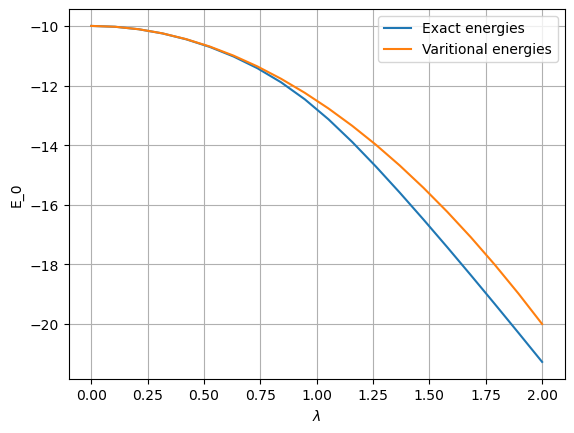

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,2,20),list_energies, label ='Exact energies')
plt.plot(np.linspace(0,2,20),list_var_energies,label ='Varitional energies')
plt.xlabel('$\lambda$')
plt.grid()
plt.ylabel('E_0')
plt.legend()

Now let's check their difference

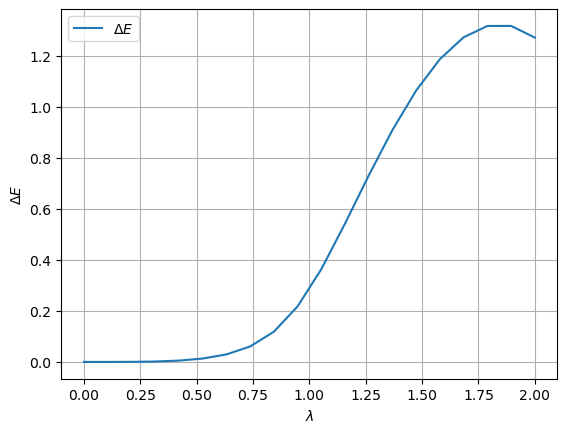

In [15]:
plt.plot(np.linspace(0,2,20),list_error, label='$\Delta E$')
plt.xlabel('$\lambda$')
plt.ylabel('$\Delta E$')
plt.grid()
plt.legend()

Now let's consider correlations. Focus of simplicity on $\lambda =1$.First let's compute in the exact state

$$ cO(i,j) =\langle O_i O_j \rangle -\langle O_i \rangle \langle O_j \rangle $$.
Notice that the only relevant thing is $|i-j|$ due to the translational invariance property of the problem 


In [76]:
def compute_magnetization(operator,state,N):
                glob_op_disc = np.kron(operator,np.eye(2**(N-1)))
                disconnected = state@glob_op_disc@state.T.conj()
                return disconnected


def compute_exact_two_b_corr(operator, state,N):
        c_i_j =[]
        distanza = []
        distanza.append(0)
        global_operator =np.kron(np.kron(operator,operator),np.eye(2**(N-2)))
        disconnected = state@global_operator@state.T.conj()
        glob_op_disc = np.kron(operator,np.eye(2**(N-1)))
        one_body = state@glob_op_disc@state.T.conj()
        c_i_j.append(disconnected-one_body**2)

        for j in range(1,N-1):
                #print(j)
                other_sep =N-2-j
                #print(other_sep)
                o_i_j= np.kron(operator,np.eye(2**j))
                o_i_j_o =np.kron(o_i_j,operator)
                global_op = np.kron(o_i_j_o,np.eye(2**other_sep))
                disconnected = state@global_op@state.T.conj()
                connected = disconnected-one_body**2 
                c_i_j.append(connected)                         
                #distanza.append(np.min([j,other_sep])) 
                distanza.append(j)
                
        return  c_i_j,distanza
    
    

-12.784906442999318
-12.784906442999324
-1.0583963033224086e-16


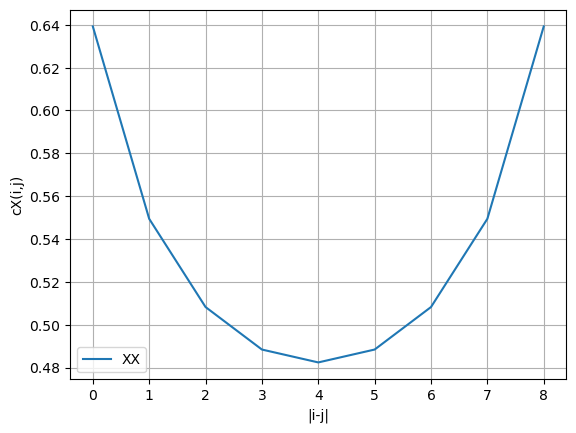

In [77]:
sigma_x = np.array([[0.,1.],[1.,0.]])
sigma_y = np.array([[0.,-1.j],[1.j,0.]])
sigma_z = np.array([[1.,0.],[0.,-1.]])
H,eig_H,U_H =build_and_diagonalize_H(N,1.)

ground_state =U_H[:,0]
energy = ground_state.T.conj()@H@ground_state
print(energy)
print(eig_H[0])
print(compute_magnetization(sigma_x,ground_state,N))
cx_i_j,distanza = compute_exact_two_b_corr(sigma_x,ground_state,N)

plt.plot(distanza,cx_i_j,label ='XX')
plt.xlabel('|i-j|')
plt.ylabel('cX(i,j)')
plt.grid()
plt.legend()

What do you expect it to be in a product state?

134087.33673974243